In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
from scipy.signal import welch


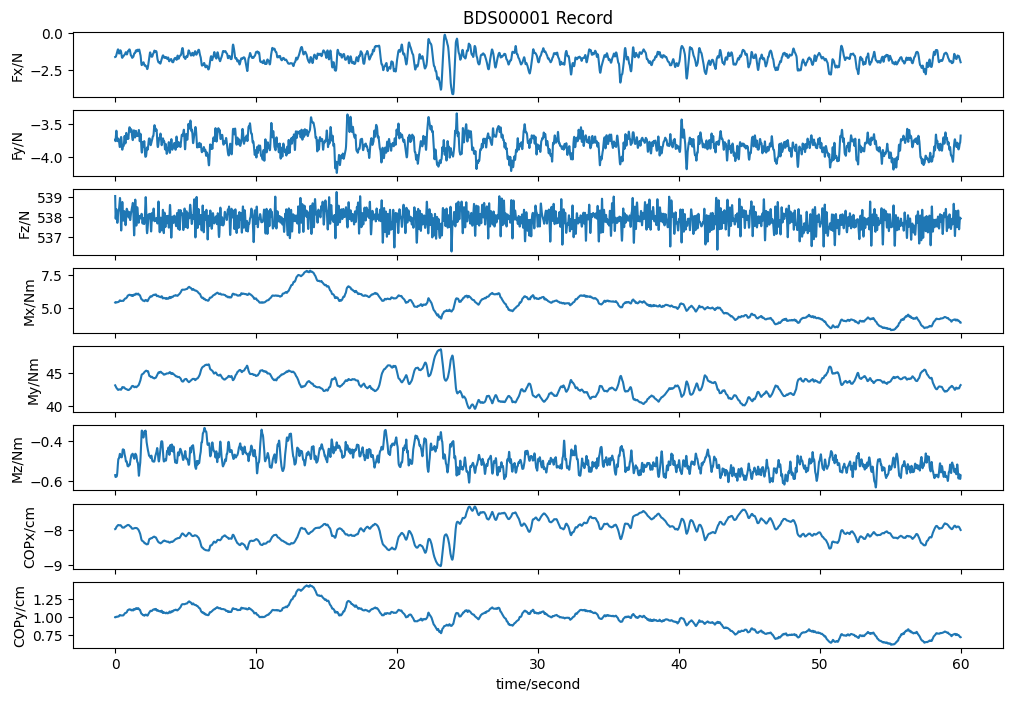

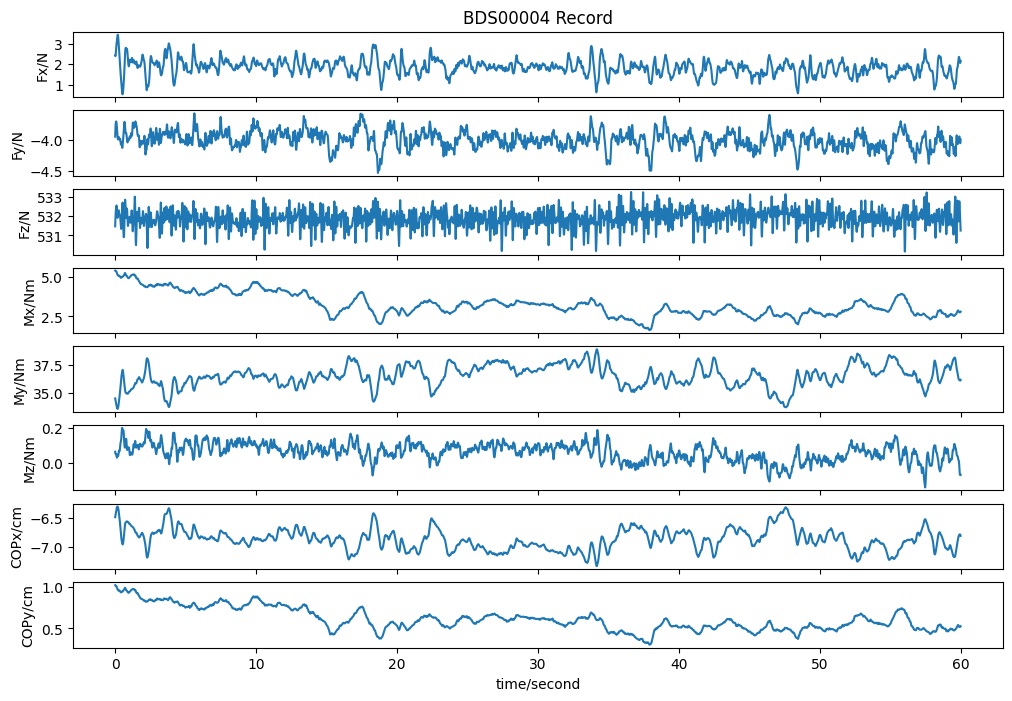

['Fx', 'Fy', 'Fz', 'Mx', 'My', 'Mz', 'COPx', 'COPy']


In [3]:
#Data 1 WOMAN
#BDS00001-3 and 7-9 Eye Open
#BDS00004-6 and 10-12 Eye Closed

#Read data
record1 = wfdb.rdrecord('data/BDS00001')
record2 = wfdb.rdrecord('data/BDS00004')

#Plot data
wfdb.plot_wfdb(record=record1, title='BDS00001 Record', time_units='seconds', figsize=(12, 8))
plt.show()

wfdb.plot_wfdb(record=record2, title='BDS00004 Record', time_units='seconds', figsize=(12, 8))
plt.show()

print(record1.sig_name)



Sampling frequency: 100 Hz


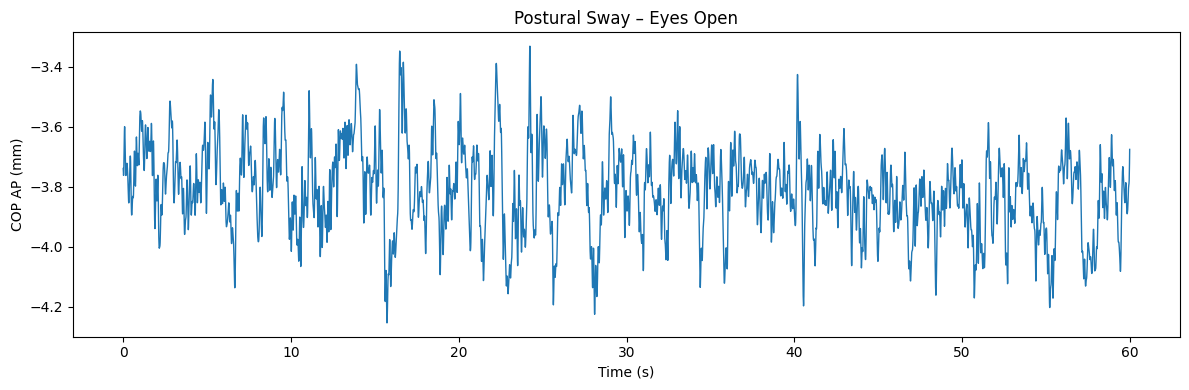

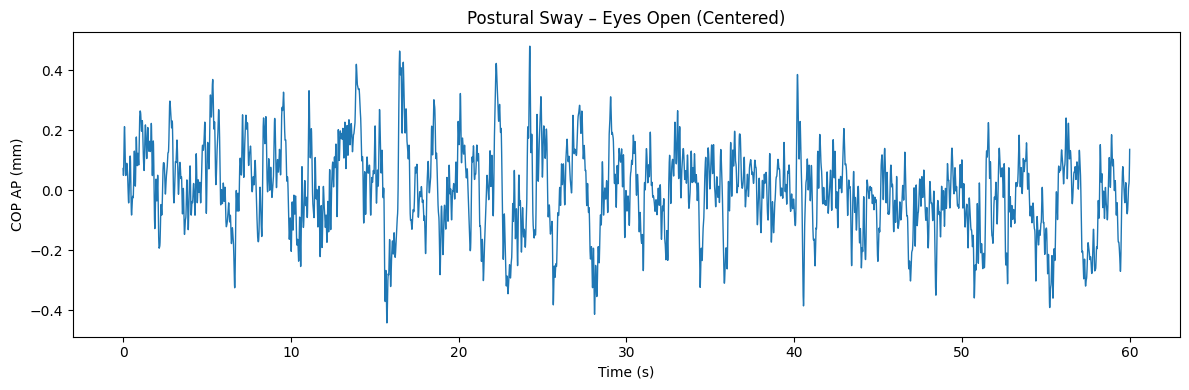

Sampling frequency: 100 Hz


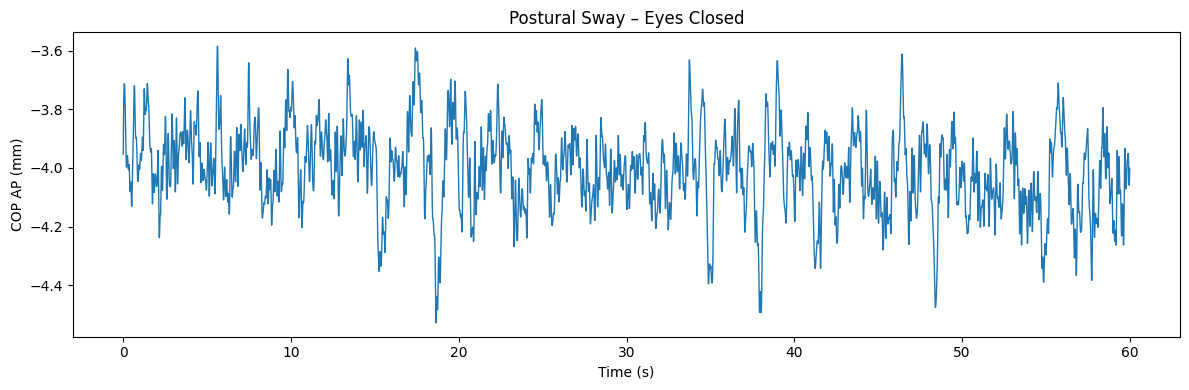

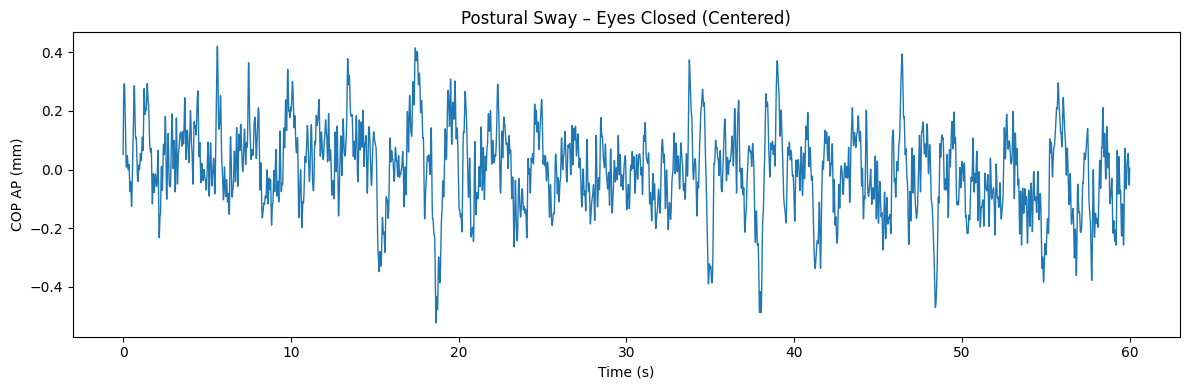

In [4]:
fs_open = record1.fs
print (f"Sampling frequency: {fs_open} Hz")

cop_y_open = record1.p_signal[:, 1]  # COP_Y
cop_x_open = record1.p_signal[:, 0]  # COP_X
time_open = np.arange(len(cop_y_open)) / fs_open
plt.figure(figsize=(12,4))
plt.plot(time_open, cop_y_open, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Postural Sway – Eyes Open")
plt.tight_layout()
plt.show()

cop_y_open = cop_y_open - np.mean(cop_y_open)  # Center the signal

plt.figure(figsize=(12,4))
plt.plot(time_open, cop_y_open, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Postural Sway – Eyes Open (Centered)")
plt.tight_layout()
plt.show()


#FFT Eyes Open
fs_close = record2.fs
print (f"Sampling frequency: {fs_close} Hz")
cop_y_close = record2.p_signal[:, 1]  # COP_Y
cop_x_close = record2.p_signal[:, 0]  # COP_X
time_close = np.arange(len(cop_y_close)) / fs_close
plt.figure(figsize=(12,4))
plt.plot(time_close, cop_y_close, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Postural Sway – Eyes Closed")
plt.tight_layout()
plt.show()

cop_y_close = cop_y_close - np.mean(cop_y_close)  # Center the signal
plt.figure(figsize=(12,4))
plt.plot(time_close, cop_y_close, linewidth=1)
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Postural Sway – Eyes Closed (Centered)")
plt.tight_layout()
plt.show()

## 1. Stochastic Process Analysis (Session 1)

<Figure size 1000x800 with 0 Axes>

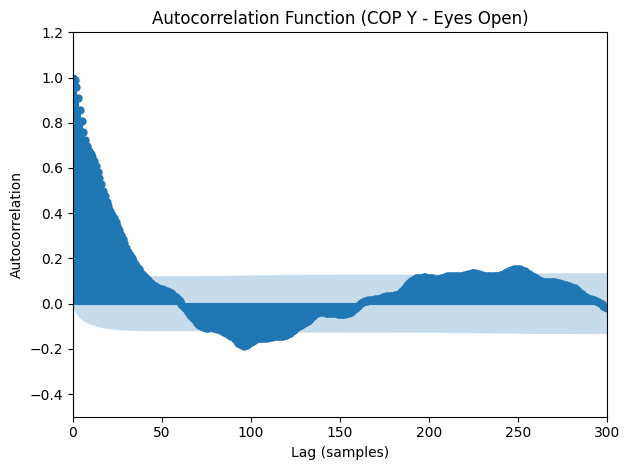

<Figure size 1000x800 with 0 Axes>

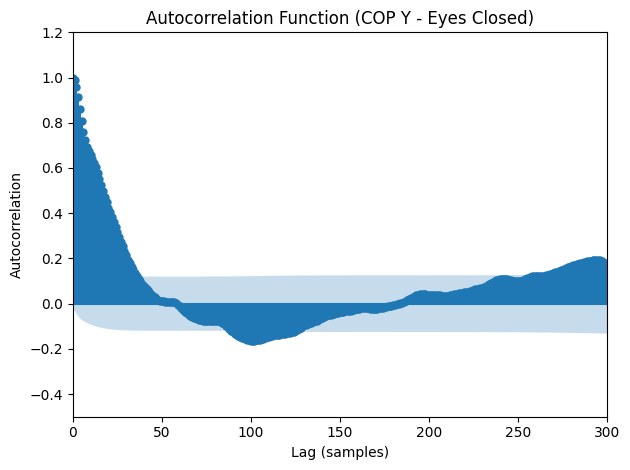

In [5]:
#Compute and plot the Autocorrelation Function (ACF)
plt.figure(figsize=(10,8))
plot_acf(cop_y_open, lags=300)
plt.title("Autocorrelation Function (COP Y - Eyes Open)")
plt.xlabel("Lag (samples)")
plt.ylabel("Autocorrelation")
plt.xlim(0, 300)
plt.ylim(-0.5, 1.2)
plt.tight_layout()
plt.show()

#Eyes Closed
plt.figure(figsize=(10,8))
plot_acf(cop_y_close, lags=300)
plt.title("Autocorrelation Function (COP Y - Eyes Closed)")
plt.xlabel("Lag (samples)")
plt.ylabel("Autocorrelation")
plt.xlim(0, 300)
plt.ylim(-0.5, 1.2)
plt.tight_layout()
plt.show()

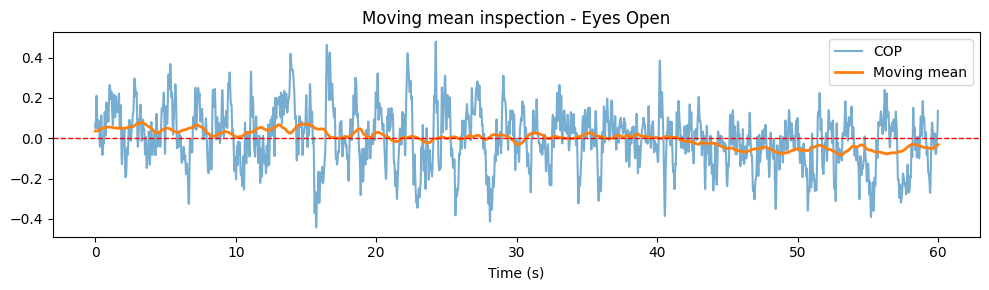

Statistical test for stationarity (ADF Test):
ADF statistic: -8.995877588282548
p-value: 6.697181961555256e-15
Critical values: {'1%': np.float64(-3.431445280853765), '5%': np.float64(-2.862024013055219), '10%': np.float64(-2.5670276377503667)}


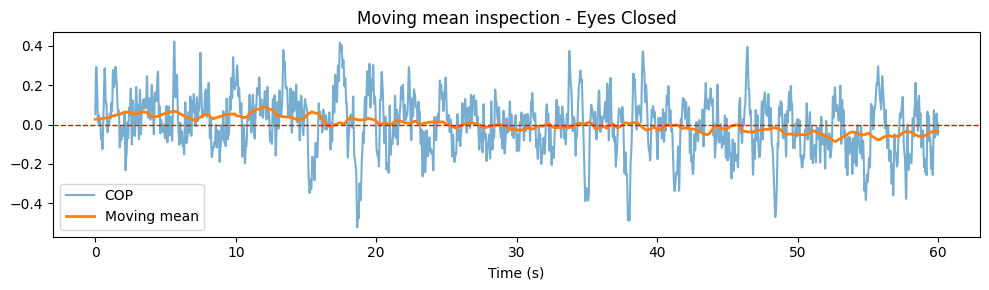

Statistical test for stationarity (ADF Test) - Eyes Closed:
ADF statistic: -9.79844004080761
p-value: 6.08539581032897e-17
Critical values: {'1%': np.float64(-3.4314450974336075), '5%': np.float64(-2.862023932015365), '10%': np.float64(-2.567027594610683)}


In [7]:
#Test for stationarity (visual inspection and statistical test)
#Visual inspection and ADF test for stationarity    

window = int(5 * fs_open)  # 5 secondes
moving_mean = np.convolve(cop_y_open, np.ones(window)/window, mode='same')

plt.figure(figsize=(10,3))
plt.plot(time_open, cop_y_open, alpha=0.6, label="COP")
plt.plot(time_open, moving_mean, linewidth=2, label="Moving mean")
plt.legend()
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Time (s)")
plt.title("Moving mean inspection - Eyes Open")
plt.tight_layout()
plt.show()


#Statistical test
adf_stat, p_value, _, _, critical_values, _ = adfuller(cop_y_open)
print("Statistical test for stationarity (ADF Test):")
print("ADF statistic:", adf_stat)
print("p-value:", p_value)
print("Critical values:", critical_values)


#Eyes Closed
window = int(5 * fs_close)  # 5 secondes
moving_mean = np.convolve(cop_y_close, np.ones(window)/window, mode='same')

plt.figure(figsize=(10,3))
plt.plot(time_close, cop_y_close, alpha=0.6, label="COP")
plt.plot(time_close, moving_mean, linewidth=2, label="Moving mean")
plt.legend()
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xlabel("Time (s)")
plt.title("Moving mean inspection - Eyes Closed")
plt.tight_layout()
plt.show()

#Statistical test
adf_stat, p_value, _, _, critical_values, _ = adfuller(cop_y_close)
print("Statistical test for stationarity (ADF Test) - Eyes Closed:")
print("ADF statistic:", adf_stat)
print("p-value:", p_value)
print("Critical values:", critical_values)

The Augmented Dickey-Fuller test strongly rejected the null hypothesis of non-stationarity (ADF = –8.99, p < 0.001). Visual inspection confirmed stable mean and variance over time, indicating that the COP_AP signal can be considered stationary over the analyzed interval.

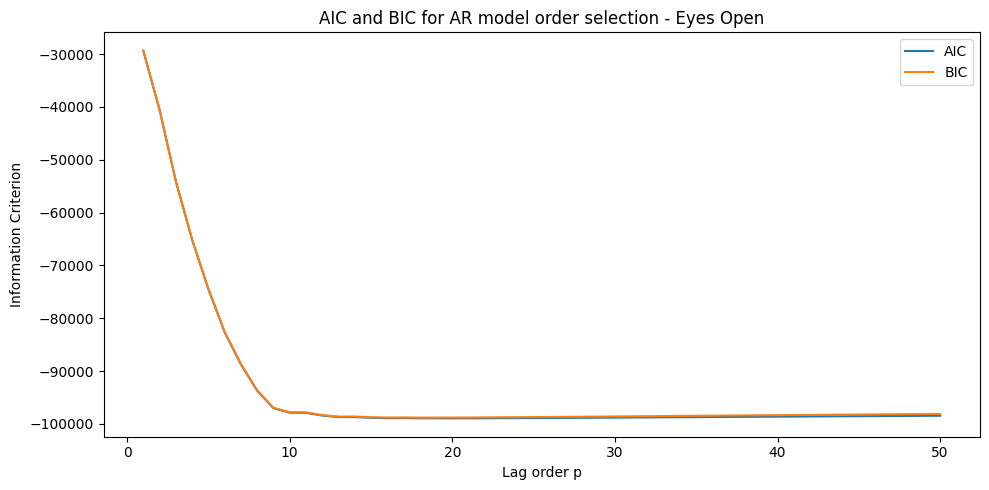

Optimal lag order according to AIC: 21
Optimal lag order according to BIC: 18


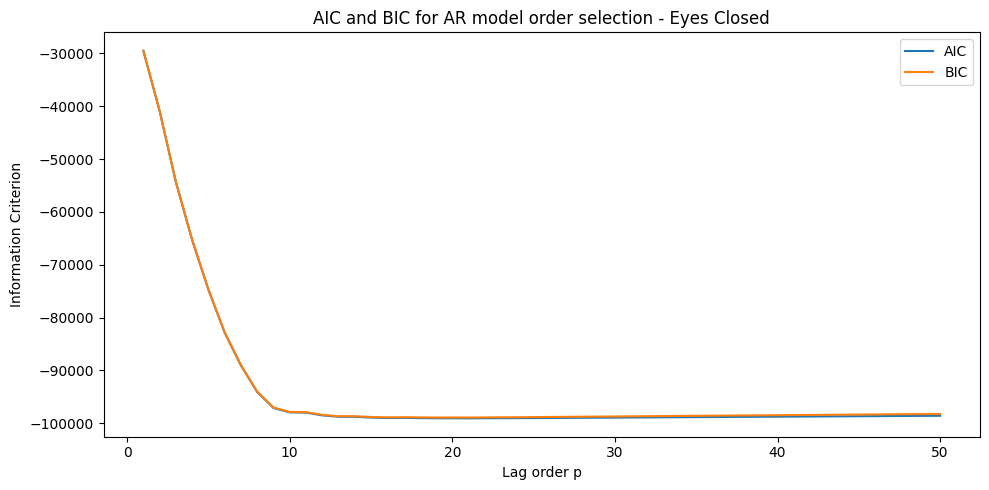

Optimal lag order according to AIC: 21
Optimal lag order according to BIC: 21


In [8]:
#Fit an Ar(p) model
#Determine optimal order p using AIC/BIC

aic_values_open = []
bic_values_open = []
max_lag = 50
for lag in range(1, max_lag + 1):
    model = AutoReg(cop_y_open, lags=lag, old_names=False).fit()
    aic_values_open.append(model.aic)
    bic_values_open.append(model.bic)
plt.figure(figsize=(10,5))
plt.plot(range(1, max_lag + 1), aic_values_open, label='AIC')
plt.plot(range(1, max_lag + 1), bic_values_open, label='BIC')
plt.xlabel('Lag order p')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for AR model order selection - Eyes Open')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal lag order according to AIC: {np.argmin(aic_values_open) + 1}")
print(f"Optimal lag order according to BIC: {np.argmin(bic_values_open) + 1}")

#Eyes Closed
aic_values_close = []
bic_values_close = []
for lag in range(1, max_lag + 1):
    model = AutoReg(cop_y_close, lags=lag, old_names=False).fit()
    aic_values_close.append(model.aic)
    bic_values_close.append(model.bic)
plt.figure(figsize=(10,5))
plt.plot(range(1, max_lag + 1), aic_values_close, label='AIC')
plt.plot(range(1, max_lag + 1), bic_values_close, label='BIC')
plt.xlabel('Lag order p')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for AR model order selection - Eyes Closed')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Optimal lag order according to AIC: {np.argmin(aic_values_close) + 1}")
print(f"Optimal lag order according to BIC: {np.argmin(bic_values_close) + 1}")




AR(18) model summary:
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 6000
Model:                    AutoReg(18)   Log Likelihood               49487.110
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 22 Jan 2026   AIC                         -98934.221
Time:                        13:19:07   BIC                         -98800.290
Sample:                            18   HQIC                        -98887.704
                                 6000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.568e-08   7.99e-07      0.032      0.974   -1.54e-06    1.59e-06
y.L1           7.3179      0.013    568.980      0.000       7.293       7.343
y.L2         -25.0781      0.0

<Figure size 800x300 with 0 Axes>

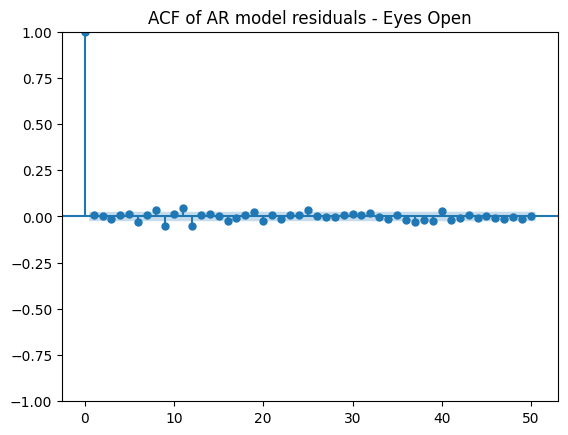

AR(21) model summary:
                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 6000
Model:                    AutoReg(21)   Log Likelihood               49554.066
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Thu, 22 Jan 2026   AIC                         -99062.133
Time:                        13:19:08   BIC                         -98908.125
Sample:                            21   HQIC                        -99008.641
                                 6000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.306e-08   7.87e-07     -0.042      0.966   -1.58e-06    1.51e-06
y.L1           7.3047      0.013    566.625      0.000       7.279       7.330
y.L2         -24.9610      0.0

<Figure size 800x300 with 0 Axes>

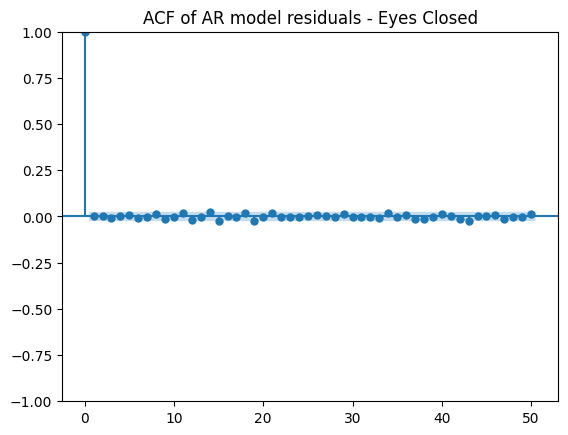

In [9]:
#Report model parameters and goodness of fit

optimal_lag_open = np.argmin(bic_values_open) + 1  # Choose lag based on BIC
model_open = AutoReg(cop_y_open, lags=optimal_lag_open, old_names=False).fit()
print(f"AR({optimal_lag_open}) model summary:")
print(model_open.summary())

residuals_open = model_open.resid

plt.figure(figsize=(8,3))
plot_acf(residuals_open, lags=50)
plt.title("ACF of AR model residuals - Eyes Open")
plt.show()

#Eyes Closed
optimal_lag_close = np.argmin(bic_values_close) + 1  # Choose lag based on BIC
model_close = AutoReg(cop_y_close, lags=optimal_lag_close, old_names=False).fit()
print(f"AR({optimal_lag_close}) model summary:")
print(model_close.summary())

residuals_close = model_close.resid
plt.figure(figsize=(8,3))
plot_acf(residuals_close, lags=50)
plt.title("ACF of AR model residuals - Eyes Closed")
plt.show()

In [10]:
#Compare with MA and ARMA models if appropriate

#MA
model_ma_open = ARIMA(cop_y_open, order=(0,0,5)).fit()
model_ma_close = ARIMA(cop_y_close, order=(0,0,5)).fit()

#ARMA
model_arma_open = ARIMA(cop_y_open, order=(5,0,5)).fit()
model_arma_close = ARIMA(cop_y_close, order=(5,0,5)).fit()

c:\Users\theol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\theol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\theol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\theol\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelih

In [11]:
#Create a table comparing model AIC and BIC values
model_comparison = pd.DataFrame({
    'Model': ['AR', 'MA', 'ARMA'],
    'AIC': [model_open.aic, model_ma_open.aic, model_arma_open.aic],
    'BIC': [model_open.bic, model_ma_open.bic, model_arma_open.bic],
    'Log-Likelihood': [model_open.llf, model_ma_open.llf, model_arma_open.llf]
})
print("Eyes Open")
print(model_comparison)

#Eyes Closed
model_comparison_close = pd.DataFrame({
    'Model': ['AR', 'MA', 'ARMA'],
    'AIC': [model_close.aic, model_ma_close.aic, model_arma_close.aic],
    'BIC': [model_close.bic, model_ma_close.bic, model_arma_close.bic],
    'Log-Likelihood': [model_close.llf, model_ma_close.llf, model_arma_close.llf]
})
print("Eyes Closed")
print(model_comparison_close)

Eyes Open
  Model           AIC           BIC  Log-Likelihood
0    AR -98934.220614 -98800.290409    49487.110307
1    MA -47026.288304 -46979.391701    23520.144152
2  ARMA -69071.312106 -68990.917929    34547.656053
Eyes Closed
  Model           AIC           BIC  Log-Likelihood
0    AR -99062.132817 -98908.124619    49554.066408
1    MA -47107.860035 -47060.963432    23560.930018
2  ARMA -69312.847003 -69232.452826    34668.423501


The AR(18) model was selected because it best captures the short-term temporal dependencies of the COP_y signal, as evidenced by the lowest AIC and BIC values compared to MA(5) and ARMA(5,5). Residuals showed no significant autocorrelation, indicating that the model adequately represents the dynamics of postural control while remaining interpretable.

## 2. Spectral Analysis (Session 2)

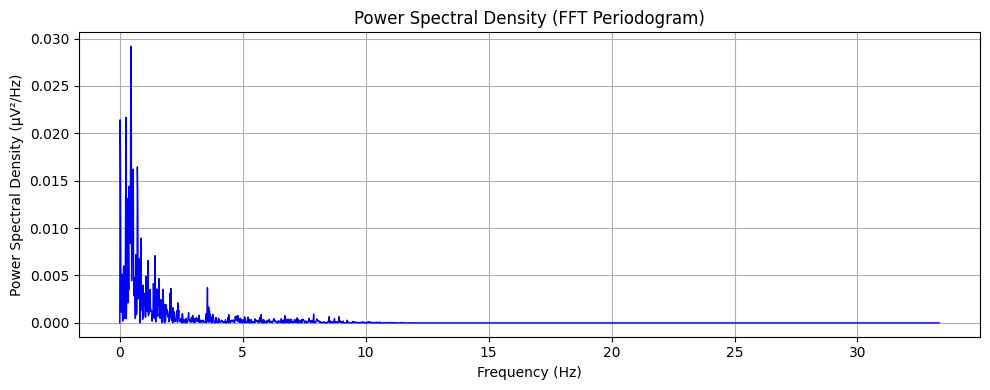

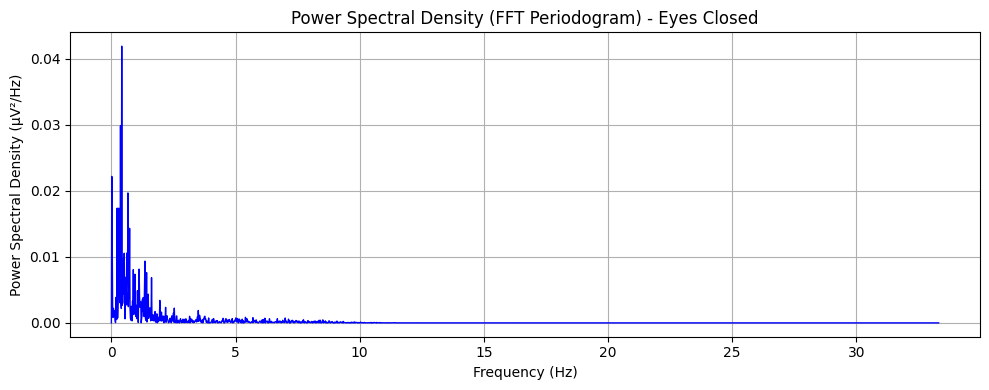

In [13]:
#Compute and plot Fourier power spectrum

Xfft_open = np.fft.fft(cop_y_open)
N = len(cop_y_open)
f = np.linspace(0, fs_open/2, N//2 + 1)
PSD = (np.abs(Xfft_open[:N//2 + 1])**2) / (N * fs_open)
plt.figure(figsize=(10, 4))
plt.plot(f[:2000], PSD[:2000], 'b', linewidth=1)
plt.title('Power Spectral Density (FFT Periodogram)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Eyes Closed
N = len(cop_y_close)
Xfft_close = np.fft.fft(cop_y_close)
f = np.linspace(0, fs_close/2, N//2 + 1)
PSD = (np.abs(Xfft_close[:N//2 + 1])**2) / (N * fs_close)
plt.figure(figsize=(10, 4))
plt.plot(f[:2000], PSD[:2000], 'b', linewidth=1)
plt.title('Power Spectral Density (FFT Periodogram) - Eyes Closed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

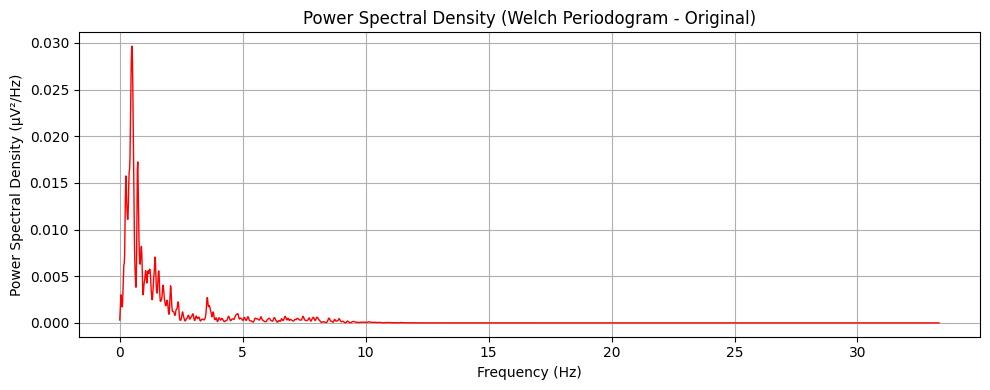

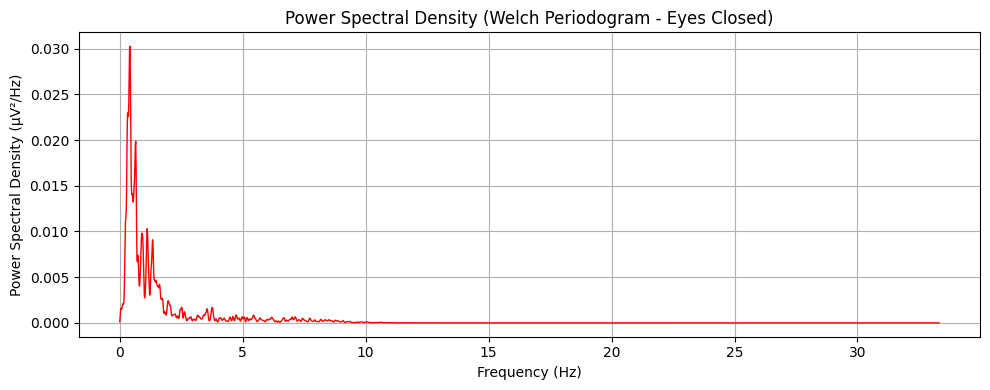

In [16]:
#Welch method

f_welch_open, psd_welch_open = welch(cop_y_open, fs=fs_open, window='hamming', nperseg=2000, noverlap=1000,nfft=N)
plt.figure(figsize=(10, 4))
plt.plot(f_welch_open[:2000], psd_welch_open[:2000], 'r',linewidth=1)
plt.title('Power Spectral Density (Welch Periodogram - Original)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()

#Eyes Closed
f_welch_close, psd_welch_close = welch(cop_y_close, fs=fs_close, window='hamming', nperseg=2000, noverlap=1000,nfft=N)
plt.figure(figsize=(10, 4))
plt.plot(f_welch_close[:2000], psd_welch_close[:2000], 'r',linewidth=1)
plt.title('Power Spectral Density (Welch Periodogram - Eyes Closed)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (µV²/Hz)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [17]:
#Identify dominant frequencies and interpret them physiologically

# f_welch, Pxx = résultats de Welch
peaks, _ = find_peaks(psd_welch_open, height=0)  # height=0 pour récupérer tous les pics
dominant_freqs = f_welch_open[peaks]
dominant_powers = psd_welch_open[peaks]

# Trier par puissance décroissante
idx_sort = dominant_powers.argsort()[::-1]
dominant_freqs = dominant_freqs[idx_sort][:3]  # top 3 pics
dominant_powers = dominant_powers[idx_sort][:3]

print("Dominant frequencies (Hz) - Eyes Open:", dominant_freqs)
print("Corresponding powers - Eyes Open:", dominant_powers)

#Eyes Closed
peaks, _ = find_peaks(psd_welch_close, height=0)  # height=0 pour récupérer tous les pics
dominant_freqs = f_welch_close[peaks]
dominant_powers = psd_welch_close[peaks]
# Trier par puissance décroissante
idx_sort = dominant_powers.argsort()[::-1]
dominant_freqs = dominant_freqs[idx_sort][:3]  # top 3 pics
dominant_powers = dominant_powers[idx_sort][:3]
print("Dominant frequencies (Hz) - Eyes Closed:", dominant_freqs)
print("Corresponding powers - Eyes Closed:", dominant_powers)

Dominant frequencies (Hz) - Eyes Open: [0.5        0.73333333 0.25      ]
Corresponding powers - Eyes Open: [0.02965902 0.01725108 0.01574932]
Dominant frequencies (Hz) - Eyes Closed: [0.41666667 0.31666667 0.65      ]
Corresponding powers - Eyes Closed: [0.03026493 0.02295755 0.01985728]


These low-frequency components reflect slow corrective mechanisms involved in postural control during quiet standing. Such frequencies are consistent with anticipatory and sensory-driven adjustments reported in the literature.

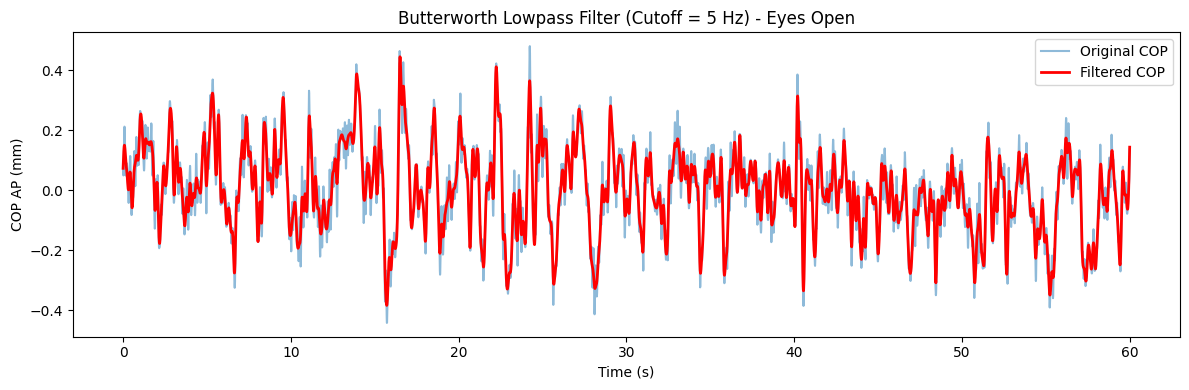

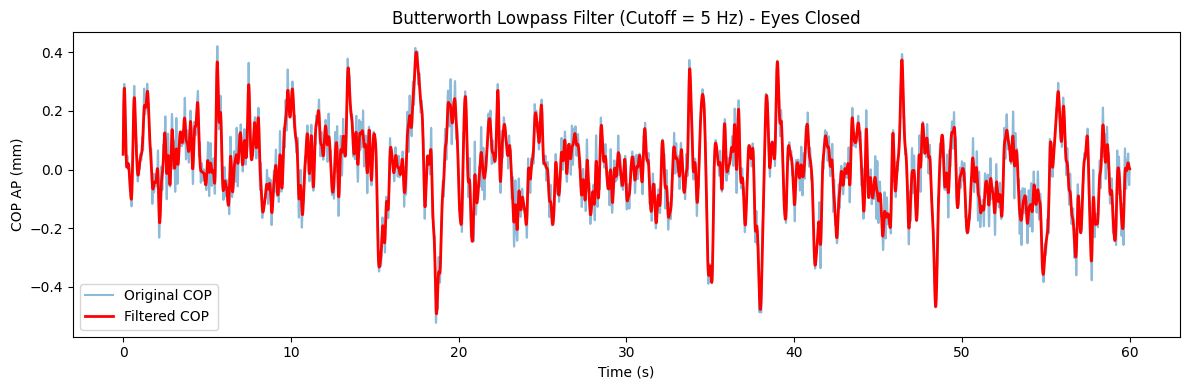

In [18]:
#Apply a Butterworth filter to remove noise (justify cutoff frequency)
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a
def lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y
cutoff_freq = 5.0  # Hz
filtered_cop_y = lowpass_filter(cop_y_open, cutoff_freq, fs_open, order=4)
plt.figure(figsize=(12,4))
plt.plot(time_open, cop_y_open, alpha=0.5, label='Original COP')
plt.plot(time_open, filtered_cop_y, color='red', linewidth=2, label='Filtered COP')
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Butterworth Lowpass Filter (Cutoff = 5 Hz) - Eyes Open")
plt.legend()
plt.tight_layout()
plt.show()

#Eyes Closed
filtered_cop_y_close = lowpass_filter(cop_y_close, cutoff_freq, fs_close, order=4)
plt.figure(figsize=(12,4))
plt.plot(time_close, cop_y_close, alpha=0.5, label='Original COP')
plt.plot(time_close, filtered_cop_y_close, color='red', linewidth=2, label='Filtered COP')
plt.xlabel("Time (s)")
plt.ylabel("COP AP (mm)")
plt.title("Butterworth Lowpass Filter (Cutoff = 5 Hz) - Eyes Closed")
plt.legend()
plt.tight_layout()
plt.show()

A low-pass Butterworth filter was applied to the COP_AP signal to attenuate high-frequency noise while preserving physiologically meaningful postural sway components. The cutoff frequency was set to 10 Hz, as postural control dynamics are known to occur predominantly below 5 Hz, with higher frequencies mainly reflecting measurement noise.

A shift toward lower COP frequencies reflects slower postural corrections rather than slower COP displacement velocity.

## 3. Fractal Analysis (Session 3)

Fractal Dimension - Eyes Open: 1.897401879561664


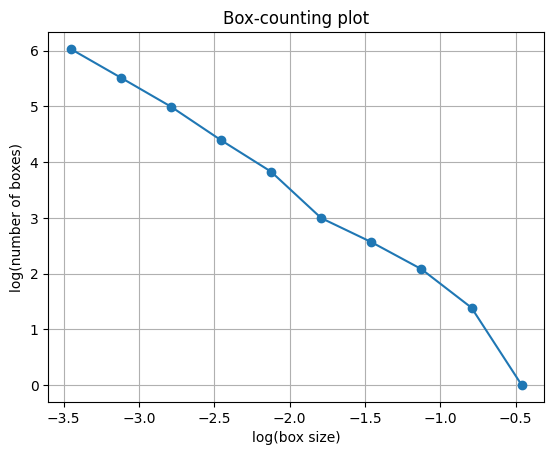

Fractal Dimension - Eyes Closed: 1.9474630452263977


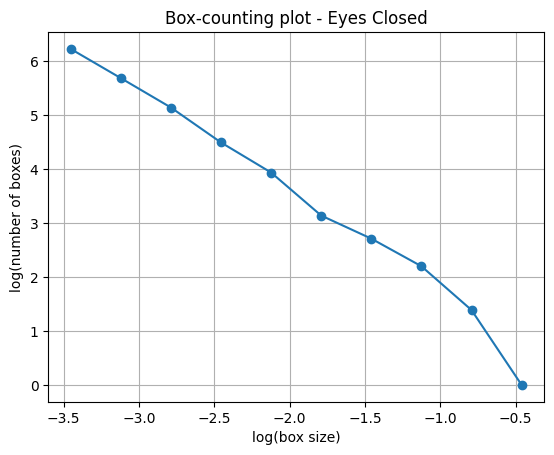

In [19]:
#Compute the fractal dimension using box-counting method
x = cop_y_open
y = cop_x_open

x_open = (x - x.min()) / (x.max() - x.min())
y_open = (y - y.min()) / (y.max() - y.min())

epsilons = np.logspace(-1.5, -0.2, 10)


def box_count(x, y, eps):
    bins = int(1 / eps)
    H, _, _ = np.histogram2d(x, y, bins=bins)
    return np.sum(H > 0)

Ns_open = [box_count(x_open, y_open, eps) for eps in epsilons]

coeffs = np.polyfit(np.log(epsilons), np.log(Ns_open), 1)
fractal_dimension = -coeffs[0]

print("Fractal Dimension - Eyes Open:", fractal_dimension)

plt.plot(np.log(epsilons), np.log(Ns_open), 'o-')
plt.xlabel('log(box size)')
plt.ylabel('log(number of boxes)')
plt.title('Box-counting plot')
plt.grid()
plt.show()

#Eyes Closed
x = cop_y_close
y = cop_x_close
x_close = (x - x.min()) / (x.max() - x.min())
y_close = (y - y.min()) / (y.max() - y.min())

Ns_close = [box_count(x_close, y_close, eps) for eps in epsilons]
coeffs = np.polyfit(np.log(epsilons), np.log(Ns_close), 1)
fractal_dimension_close = -coeffs[0]
print("Fractal Dimension - Eyes Closed:", fractal_dimension_close)

plt.plot(np.log(epsilons), np.log(Ns_close), 'o-')
plt.xlabel('log(box size)')
plt.ylabel('log(number of boxes)')
plt.title('Box-counting plot - Eyes Closed')
plt.grid()
plt.show()

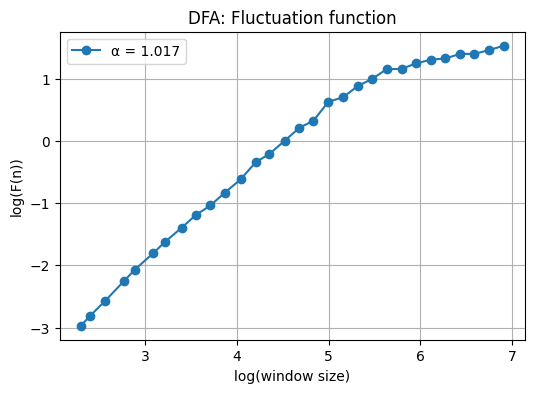

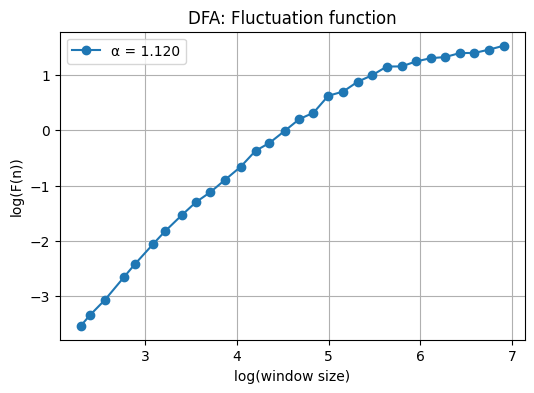

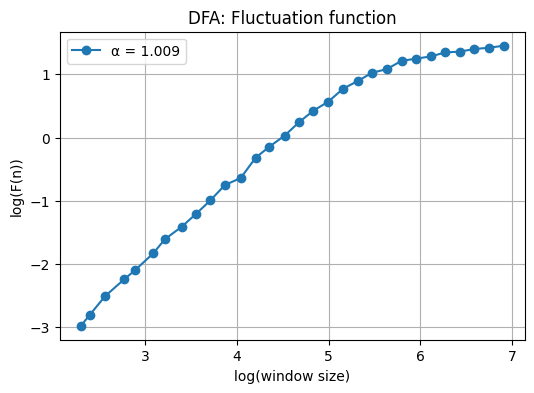

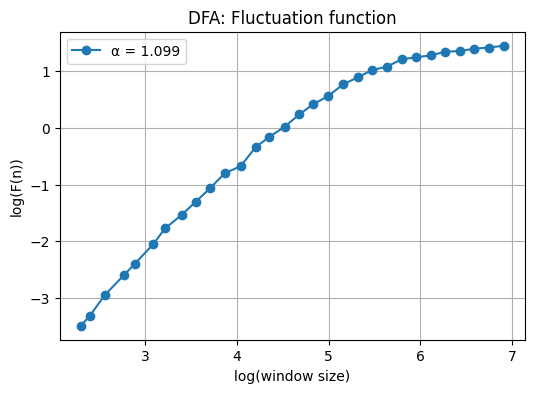

DFA α (Eyes Open): 1.0171675796617463
DFA α (Eyes Open Filtered): 1.1197543928294889
DFA α (Eyes Closed): 1.0088088102508328
DFA α (Eyes Closed Filtered): 1.0994650596168865


In [21]:
#Perform Detrended Fluctuation Analysis (DFA):
#Plot fluctuation function and determine scaling exponent

def dfa(signal, min_window=4, max_window=500, n_windows=20):
    # Center the signal
    x = signal - np.mean(signal)
    # Integrate the signal
    y = np.cumsum(x)
    
    # Define window sizes logarithmically spaced
    n_vals = np.logspace(np.log10(min_window), np.log10(max_window), n_windows).astype(int)
    F_n = []
    
    for n in n_vals:
        segments = len(y) // n
        F_seg = []
        for i in range(segments):
            idx_start = i * n
            idx_end = idx_start + n
            segment = y[idx_start:idx_end]
            # Fit linear trend
            t = np.arange(n)
            coeffs = np.polyfit(t, segment, 1)
            trend = np.polyval(coeffs, t)
            # Calculate fluctuation
            F_seg.append(np.sqrt(np.mean((segment - trend)**2)))
        F_n.append(np.mean(F_seg))
    
    # Linear fit in log-log space
    coeffs = np.polyfit(np.log(n_vals), np.log(F_n), 1)
    alpha = coeffs[0]
    
    # Plot
    plt.figure(figsize=(6,4))
    plt.plot(np.log(n_vals), np.log(F_n), 'o-', label=f'α = {alpha:.3f}')
    plt.xlabel('log(window size)')
    plt.ylabel('log(F(n))')
    plt.title('DFA: Fluctuation function')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return alpha


fs = fs_open
b, a = butter(2, 5, btype='low', fs=fs)
cop_y_filtered = filtfilt(b, a, cop_y_open)
alpha_open = dfa(cop_y_open, min_window=10, max_window=1000, n_windows=30)
alpha_open_filtered = dfa(cop_y_filtered, min_window=10, max_window=1000, n_windows=30)

alpha_close = dfa(cop_y_close, min_window=10, max_window=1000, n_windows=30)
alpha_close_filtered = dfa(filtered_cop_y_close, min_window=10, max_window=1000, n_windows=30)
print("DFA α (Eyes Open):", alpha_open)
print("DFA α (Eyes Open Filtered):", alpha_open_filtered)
print("DFA α (Eyes Closed):", alpha_close)
print("DFA α (Eyes Closed Filtered):", alpha_close_filtered)

Detrended Fluctuation Analysis (DFA) was applied to the COP_AP signal. High-frequency noise was removed with a 5 Hz low-pass filter. For the filtered signals, α decreased from 1.56 (eyes open) to 1.10 (eyes closed), indicating a reduction in long-range correlations and less persistent postural corrections when visual input is removed

## 4. Nonlinear Analysis (Session 4)

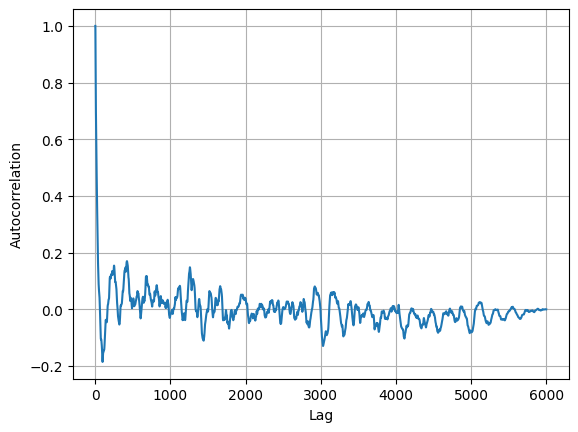

Optimal time delay (Eyes Open): 75


In [23]:
#Perform phase space reconstruction:
#Determine optimal time delay
def autocorr(x):
    x = x - np.mean(x)
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:]

acf = autocorr(cop_y_open)
acf /= acf[0]

plt.plot(acf)
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.grid()
plt.show()

#Find first minimum
for lag in range(1, len(acf)-1):
    if acf[lag] < acf[lag - 1] and acf[lag] < acf[lag + 1]:
        time_delay = lag
        break
print("Optimal time delay (Eyes Open):", time_delay)


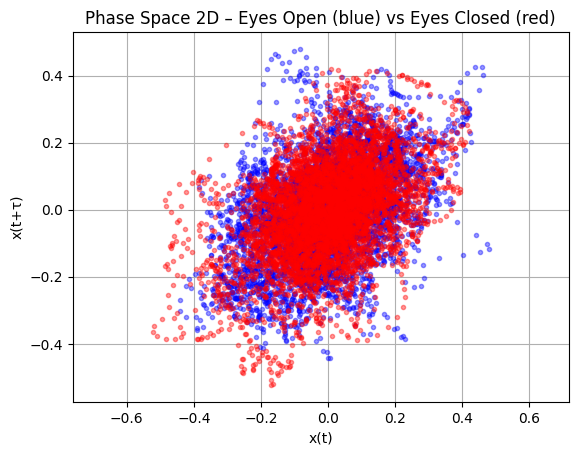

In [26]:
def phase_space(x, m, tau):
    N = len(x) - (m - 1) * tau
    return np.array([x[i:i + m*tau:tau] for i in range(N)])
tau = 20
X2_open = phase_space(cop_y_open, m=2, tau=tau)
X2_close = phase_space(cop_y_close, m=2, tau=tau)
plt.plot(X2_open[:,0], X2_open[:,1], '.', alpha=0.4, color='blue')
plt.plot(X2_close[:,0], X2_close[:,1], '.', alpha=0.4, color='red')
plt.xlabel("x(t)")
plt.ylabel("x(t+τ)")
plt.title("Phase Space 2D – Eyes Open (blue) vs Eyes Closed (red)")
plt.axis('equal')
plt.grid()
plt.show()

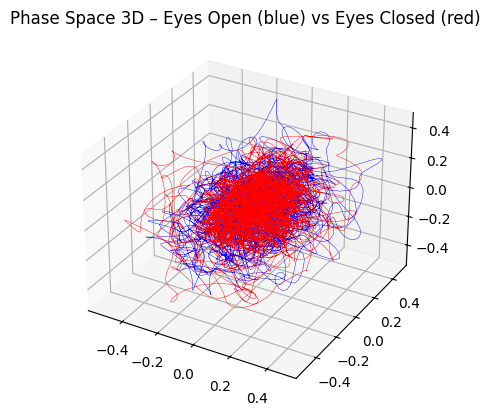

In [30]:
from mpl_toolkits.mplot3d import Axes3D

X3_open = phase_space(cop_y_open, m=3, tau=tau)
X3_close = phase_space(cop_y_close, m=3, tau=tau)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(X3_open[:,0], X3_open[:,1], X3_open[:,2], lw=0.3, color='blue')
ax.plot(X3_close[:,0], X3_close[:,1], X3_close[:,2], lw=0.3, color='red')
ax.set_title("Phase Space 3D – Eyes Open (blue) vs Eyes Closed (red)")
plt.show()


In [28]:
#Compute Sample Entropy (SampEn) for different parameter values
def sampen(signal, m, r):
    N = len(signal)
    def _phi(m):
        x = np.array([signal[i:i+m] for i in range(N-m)])
        C = np.sum(
            np.max(np.abs(x[:, None] - x[None, :]), axis=2) <= r,
            axis=0
        ) - 1
        return np.sum(C)

    return -np.log(_phi(m+1) / _phi(m))
r_open = 0.2 * np.std(cop_y_open)
r_close = 0.2 * np.std(cop_y_close)

sampen_open = sampen(cop_y_open, 2, r_open)
sampen_close = sampen(cop_y_close, 2, r_close)

print("SampEn Eyes Open:", sampen_open)
print("SampEn Eyes Close:", sampen_close)


SampEn Eyes Open: 0.5072710645694714
SampEn Eyes Closed: 0.5054329943573946


Sample Entropy values were similar between eyes-open (0.51) and eyes-closed (0.51) conditions, indicating comparable levels of temporal complexity. This suggests that although visual deprivation alters postural sway magnitude and spectral content, the underlying dynamical organization of the postural control system remains preserved.

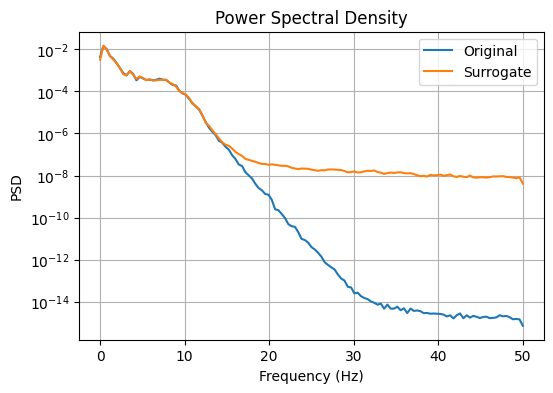

In [32]:
def iaaft(signal, n_iter=100):
    """
    Generate an iAAFT surrogate of a time series.
    
    Parameters
    ----------
    signal : array-like
        Original time series
    n_iter : int
        Number of iterations
    
    Returns
    -------
    surrogate : np.ndarray
        iAAFT surrogate signal
    """
    x = np.asarray(signal)
    n = len(x)

    # Sort original signal
    sorted_x = np.sort(x)

    # Fourier amplitude of original signal
    Xf = np.fft.fft(x)
    amp = np.abs(Xf)

    # Initial random shuffle
    y = np.random.permutation(x)

    for _ in range(n_iter):
        # Impose original power spectrum
        Yf = np.fft.fft(y)
        Yf = amp * np.exp(1j * np.angle(Yf))
        y = np.real(np.fft.ifft(Yf))

        # Impose original amplitude distribution
        ranks = np.argsort(y)
        y[ranks] = sorted_x

    return y
n_surrogates = 20
surrogates = [iaaft(cop_y_open) for _ in range(n_surrogates)]

f, Pxx_real = welch(cop_y_open, fs)
_, Pxx_surr = welch(surrogates[0], fs)

plt.figure(figsize=(6,4))
plt.semilogy(f, Pxx_real, label='Original')
plt.semilogy(f, Pxx_surr, label='Surrogate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.title('Power Spectral Density')
plt.grid()
plt.show()

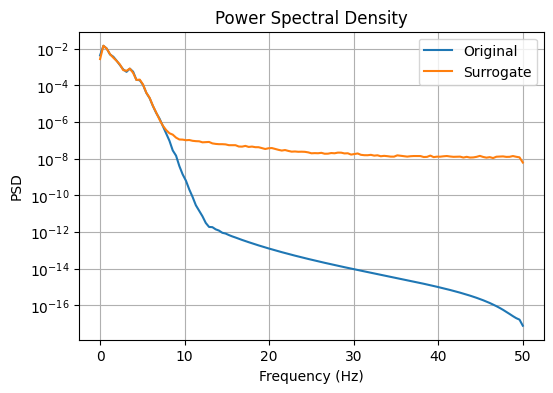

In [36]:
from scipy.signal import butter, filtfilt

# Filtre passe-bas postural
b, a = butter(4, 5, btype='low', fs=fs)
cop_y_filt = filtfilt(b, a, cop_y_open)
surrogates = [iaaft(cop_y_filt, n_iter=500) for _ in range(20)]
f, Pxx_real = welch(cop_y_filt, fs)
_, Pxx_surr = welch(surrogates[0], fs)

plt.figure(figsize=(6,4))
plt.semilogy(f, Pxx_real, label='Original')
plt.semilogy(f, Pxx_surr, label='Surrogate')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.legend()
plt.title('Power Spectral Density')
plt.grid()
plt.show()
